In [11]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

#set font size of labels on matplotlib plots
plt.rc('font', size=16)

#define a custom palette
customPalette = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=customPalette)

In [19]:
t = 100   #number of timepoints
n = 20    #number of timeseries
bias = 0.1  #bias in random walk

#generate "biased random walk" timeseries
data = pd.DataFrame(np.reshape(np.cumsum(np.random.randn(t,n)+bias,axis=0),(t,n)))
#np.random.randn return values from standard normal distribution
data.head()

,0,1,2,3,4,5,6,7,8,9,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
0,-0.148353,-0.618247,-0.981447,-0.506471,0.035779,0.786495,-0.682883,1.575431,0.124913,-0.903181,...,-0.711801,-0.995401,-0.935822,-0.763970,-1.809018,-0.193569,-0.442597,-0.467099,-1.369757,1.026359
1,0.520406,-2.765326,-0.451909,-1.673170,-1.496673,0.716395,-1.417502,0.930959,0.298592,-1.487492,...,-0.486352,-1.756181,-2.202829,-1.419161,-2.301907,-0.158721,-1.157465,-0.209301,-3.095473,1.710235
2,-0.316510,-3.607691,0.342342,-0.657444,-2.120787,1.909653,-0.533970,0.299288,0.766071,-1.642879,...,1.108288,-1.859984,-2.653286,-1.718880,-1.056756,-0.921879,-1.002326,1.015293,-1.320599,2.377264
3,-0.210132,-3.332912,1.050381,-0.556253,-1.458927,0.548707,-0.058954,-2.043165,1.019666,0.879461,...,0.790690,-2.783236,-4.890356,-0.794948,-1.271683,-1.030728,-0.931468,0.570938,-1.079139,2.692401
4,-1.145499,-3.016168,2.492937,-2.175710,-1.324556,-0.837360,1.161670,-2.237072,0.274214,0.999332,...,0.110123,-1.726760,-5.380461,0.095991,-0.881870,-1.288239,-1.471488,-0.284620,-0.631643,1.865136


In [20]:
def drift_diffusion_plot(values, upperbound, lowerbound, 
                         upperlabel='', lowerlabel='', 
                         stickybounds=True, **kwargs):
    """
    Creates a formatted drift-diffusion plot for a given timeseries.
    
    Inputs:
       - values: array of values in timeseries
       - upperbound: numeric value of upper bound
       - lowerbound: numeric value of lower bound
       - upperlabel: optional label for upper bound
       - lowerlabel: optional label for lower bound
       - stickybounds: if true, timeseries stops when bound is hit
       - kwargs: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html
    
    Output:
       - ax: handle to plot axis
    """
    
    #if bounds are sticky, hide timepoints that follow the first bound hit
    if stickybounds:
        #check to see if (and when) a bound was hit
        bound_hits = np.where((values>upperbound) | (values<lowerbound))[0]
        #if a bound was hit, replace subsequent values with NaN
        if len(bound_hits)>0:
            values = values.copy()
            values[bound_hits[0]+1:] = np.nan
    
    #plot timeseries
    ax = plt.gca()
    plt.plot(values, **kwargs)
    
    #format plot
    ax.set_ylim(lowerbound, upperbound)
    ax.set_yticks([lowerbound,upperbound])
    ax.set_yticklabels([lowerlabel,upperlabel])
    ax.axhline(y=np.mean([upperbound, lowerbound]), color='lightgray', zorder=0)
    ax.set_xlim(0,len(values))
    ax.set_xlabel('time')
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    return ax

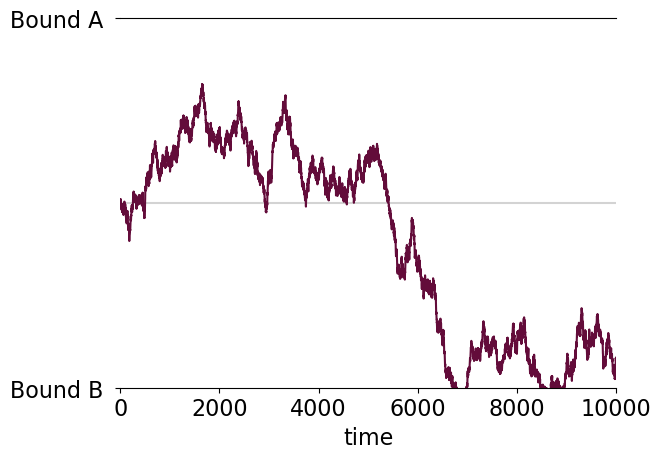

In [21]:
ax = drift_diffusion_plot(data.iloc[:,3], upperbound=100, lowerbound=-100, 
                          upperlabel='Bound A ', lowerlabel='Bound B ', 
                          stickybounds=False)

In [8]:
np.random.randn(t,n)

array([[ 0.02717837,  0.28137898, -0.09633027, ...,  2.29970782,
         0.94941438,  1.08017824],
       [ 1.4475934 ,  1.17161042,  1.17362944, ...,  0.48471097,
        -0.65272319, -0.80816496],
       [-0.47051275, -1.98591712, -0.86057352, ..., -0.50479608,
         0.82163496, -0.98676229],
       ...,
       [ 0.60631749, -1.79170372,  1.56362588, ...,  0.27701938,
        -0.83720012,  0.52245697],
       [ 1.72693937, -0.14807748, -0.16986177, ...,  1.05862924,
        -1.10477974, -0.91609231],
       [ 0.5278488 ,  0.20125306,  0.38253747, ...,  0.45864066,
        -2.51652736,  0.69397881]])

In [29]:
import numpy as np

def drift_diffusion_model(v, a, Ter, dt, max_t):
    """
    Simulates a drift-diffusion model for decision making.
    
    Args:
        v (float): Drift rate (decision criterion).
        a (float): Boundary separation (threshold for making a decision).
        Ter (float): Non-decision time (e.g., encoding, motor response, etc.).
        dt (float): Time step for simulation.
        max_t (float): Maximum time allowed for the decision process.
        
    Returns:
        decision (int): 1 if decision is 'A', -1 if decision is 'B'.
        rt (float): Response time.
    """
    t = 0
    x = 0
    
    while t < max_t:
        drift = v * dt + np.random.normal(0, np.sqrt(dt))  # Drift process with noise
        x += drift
        
        if x >= a:
            return 1, t + Ter  # Decision 'A' reached
        elif x <= -a:
            return -1, t + Ter  # Decision 'B' reached
        
        t += dt
    
    return 0, max_t + Ter  # No decision reached within time limit

# Example Usage
v = 0.1  # Drift rate
a = 1.0  # Boundary separation
Ter = 0.2  # Non-decision time
dt = 0.01  # Time step
max_t = 2.0  # Maximum allowed time

decision, rt = drift_diffusion_model(v, a, Ter, dt, max_t)

if decision == 1:
    print("Decision: 'A'")
elif decision == -1:
    print("Decision: 'B'")
else:
    print("No decision reached within time limit")
    
print(f"Response time: {rt} seconds")

Decision: 'B'
Response time: 0.6700000000000003 seconds


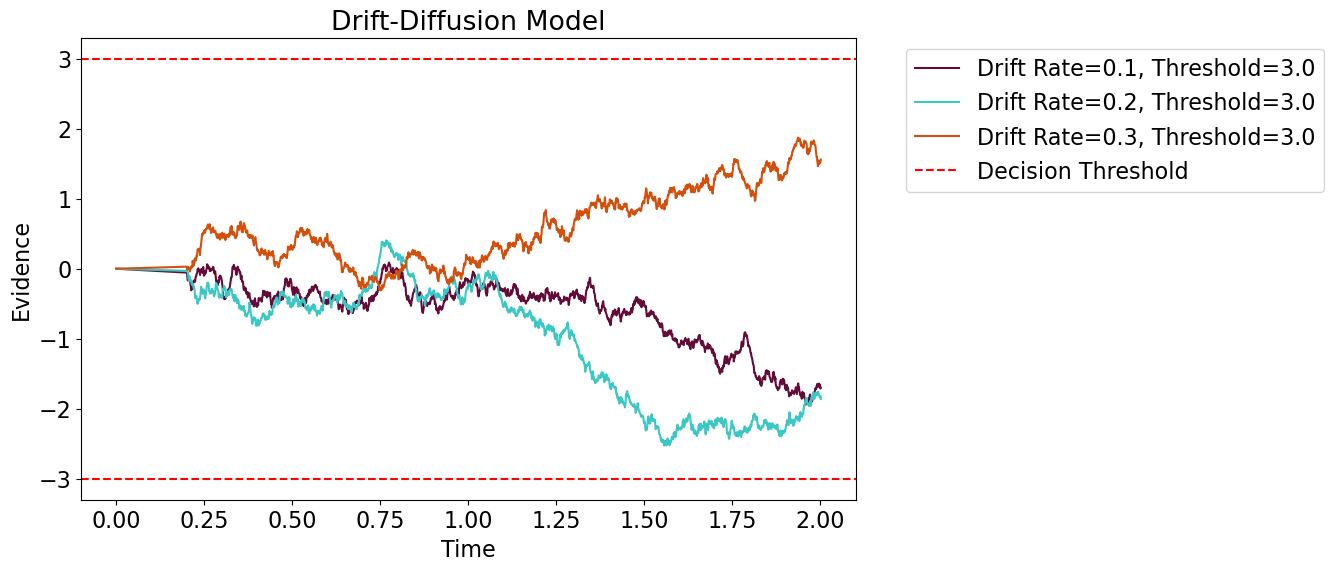

In [75]:
import matplotlib.pyplot as plt

def plot_drift_diffusion(v, a, Ter, dt, max_t, bias):
    t = 0
    x = 0
    
    time_points = [t]
    evidence = [x]
    
    while t+Ter < max_t:
        drift = (v+bias) * dt + np.random.normal(0, np.sqrt(dt))
        x += drift
        
        t += dt
        
        time_points.append(t + Ter)
        evidence.append(x)
        
        if x >= a or x <= -a:
            break
    
    plt.plot(time_points, evidence, label=f'Drift Rate={v}, Threshold={a}')

# Example Usage
v_values = [0.1, 0.2, 0.3]  # List of different drift rates
a = 3.0
Ter = 0.2
dt = 0.001
max_t = 2.0
bias = 0.1

plt.figure(figsize=(10, 6))

for v in v_values:
    plot_drift_diffusion(v, a, Ter, dt, max_t, bias)

plt.xlabel('Time')
plt.ylabel('Evidence')
plt.title('Drift-Diffusion Model')
plt.axhline(a, color='red', linestyle='--', label='Decision Threshold')
plt.axhline(-a, color='red', linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()